# Importing libraries

In [30]:
import time

In [3]:
%cd '/content/drive/MyDrive/Colab Notebooks/ML_Project'

/content/drive/MyDrive/Colab Notebooks/ML_Project


#### In this cell we have imported all the necessary libraries which are used in the project

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import glob
import shutil
import random
import cv2
from tqdm import tqdm
from PIL import Image
from IPython.display import clear_output

#### This is the code which used to mount google drive so that we can seamlessly create dataset and store results in it through google collab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install fastai --upgrade

#### In this cell I have downloaded the coco dataset from fast ai

In [6]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True
coco_images = glob.glob(coco_path + '/*.jpg')
print(type(coco_images))
print(len(coco_images))

<class 'list'>
21837


In [7]:
#copied is the var to verify if the image has been copied to the destination folder
copied= True
# to check if the dataset has been resized
resizedvar = False

#### This is the function which is used to resize the images using PIL method of interpolating which will be used to make dataloader

In [8]:
#Using PIL method of interpolating
#removing asarray
def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

#### In this cell firstly we are  copying random 9000 images from dataset  to google drive folder 
#### After this we  split the 9000 images into training and testing dataset. 
#### we will be using 7000 images to train the model while remaining images will be used to test the performance of the model

In [10]:
dest = 'dataset'
#initialize lists
train_imgs =[]
test_imgs =[]
#checking if images are copied
if not copied:
    np.random.seed(1334)
    subset_coco = np.random.choice(coco_images, 9000, replace=False)
    randomindices = np.random.permutation(9000)

    for i in tqdm(range(len(randomindices))):
        try:
            shutil.copy(str(subset_coco[i]),dest)
            print('s')
            
        except shutil.SameFileError:
            print("Source and destination represents the same file.")

        # If there is any permission issue
        except PermissionError:
            print("Permission denied.")

        # For other errors
        except:
            print("Error occurred while copying file.")
                                              
    copied = True   
    
data_images = glob.glob(dest + "/*.jpg")
print(len(data_images))

#checking if images are resized
if not resizedvar:
    resized_imgs = []
    for i in tqdm(data_images):
        im = Image.open(i)
        im = np.array(im)
        resized = resize_img(im)
        resized_imgs.append(resized)        
    resizedvar = True
    
#allocating the training images and testing images with random indices    
randidxdata = np.random.permutation(8997)
trainingidx = randidxdata[:7000]
testidx = randidxdata[7000:]

#for loops to assign the images
for i in tqdm(trainingidx):
    train_imgs.append(resized_imgs[i])
    
for i in tqdm(testidx):
    test_imgs.append(resized_imgs[i])    

9000


100%|██████████| 1997/1997 [00:00<00:00, 790638.58it/s]


# Dataloader
#### Now in this cell we are resizing the images and flipping horizontally (flipping only if it is training set) 
#### After this we read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models respectively. 

In [11]:
class ColorData(Dataset):
    def __init__(self, train = 1):
        #data = resized_imgs
        if train == 1:
            self.images = train_imgs
            self.transforms = transforms.Compose([
                transforms.RandomHorizontalFlip(),
            ])
        elif train == 0:
            self.images = test_imgs
        
        self.train = train
        self.images = self.images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx]).convert('RGB')
        lab_imgs = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        lab_imgs = transforms.ToTensor()(lab_imgs)
        L = lab_imgs[[0], ...] / 50. - 1. # Between -1 and 1
        ab = lab_imgs[[1, 2], ...] / 110. # Between -1 and 1
        
        return L, ab

In [12]:
traindataset = ColorData(train = 1)
trainloader = DataLoader(traindataset, batch_size=10, shuffle=True, num_workers=0)

testdataset = ColorData(train = 0)
testloader = DataLoader(testdataset, batch_size=10, num_workers=0)


Checking the output of the dataloader

In [13]:
data = next(iter(trainloader))
Ls, ab = data
print(Ls.shape, ab.shape)
print(len(trainloader), len(testloader))

torch.Size([10, 1, 256, 256]) torch.Size([10, 2, 256, 256])
700 200


# Generator Network

In this section we have implemented the Generator Network
<ol>    
<li> This code implements the U-Net which is to be used as the generator of our GAN. </li>
<li>The implemented code makes the U-Net from the middle part of it and adds down-sampling and up-sampling modules to the left and right of that middle module respectively at every iteration until it reaches the input module and output module.</li>
</ol>   


## Singular Unet Block

In [14]:
class UnetBlk(nn.Module):
    def __init__(self, filnum, co, submodule=None, in_channel=None, bottleneck=False, outermost=False):
        super().__init__()
        #variable to check if current layer is the outermost layer
        self.outermost = outermost
        
        #if not specified, input channel = ci
        if in_channel is None: 
            in_channel = filnum
            
        #initializing the layers
        downconv = nn.Conv2d(in_channel, co, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(co)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(filnum)
        
        if outermost:
            upconv = nn.ConvTranspose2d(co * 2, filnum, kernel_size=4,stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        
        elif bottleneck:
            upconv = nn.ConvTranspose2d(co, filnum, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        
        else:
            upconv = nn.ConvTranspose2d(co * 2, filnum, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            model = down + [submodule] + up
        
        #creating the model from the list
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

## Unet Network

In [15]:
class Unet(nn.Module):
    def __init__(self, in_channel=1, out_channel=2, layers=8, filnum=64):
        super().__init__()
        
        #bottleneck layer
        unetblock = UnetBlk(filnum * 8, filnum * 8, bottleneck=True)
        
        #next 3 layers
        for i in range(layers - 5):
            unetblock = UnetBlk(filnum * 8, filnum * 8, submodule=unetblock)
        
        filout = filnum * 8
        
        #next 3 layers
        for i in range(3):
            unetblock = UnetBlk(filout // 2, filout, submodule=unetblock)
            filout //= 2
        
        #final layer
        self.model = UnetBlk(out_channel, filout, in_channel=in_channel, submodule=unetblock, outermost=True)
    
    def forward(self, x):
        return self.model(x)

# Discriminator Network

In this section we have implemented the Patch Discriminator

Firstly, let's see what a vanilla discriminator does:
So, In Vanilla Discriminator the model outputs one number which represents how much the model thinks the input is real.
    
Where as in a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately.

Using such a model for the task of colorization seems reasonable because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. 
Here, the model’s output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.


In [16]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        
        model = [self.get_layers(input_c, num_filters, norm=False)]
        
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
            
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Loss Calculation

In this cell we have implemented a handy class we can use to calculate the GAN loss of our final model.

In the __init__ we decide which kind of loss we’re going to use and register some constant tensors as the “real” and “fake” labels. 

Then when we call this module, it makes an appropriate tensor full of zeros or ones and computes the loss.

In [17]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# Function to initialize the weights of the networks

In this function we have initialized the weights of the network.

In [18]:
def init_model(net, device, gain=0.02, Gen=False):
    
    net = net.to(device)
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    
    net.apply(init_func)
    
    if Gen:
        print(f"Generator initialized with norm initialization")
        
    else:
        print(f"Discriminator initialized with norm initialization")
        
    return net

# Compiling the entire Network (U net Generator & Patch Discriminator)

This class brings together all the previous parts and implements a few methods to take care of training our complete model.



In [19]:
class Network(nn.Module):  
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, beta1=0.5, beta2=0.999, lambda_L1=100.):
    #beta2 is the default value    
        
        super().__init__()
        
        self.device = torch.device('cuda:0')
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(in_channel=1, out_channel=2, layers=8, filnum=64), device = self.device, Gen = True)
        else:
            self.net_G = net_G.to(self.device)
        
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), device = self.device)
        self.GANcriterion = GANLoss().to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data[0].to(self.device)
        self.ab = data[1].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

model = Network()

Generator initialized with norm initialization
Discriminator initialized with norm initialization


# Defining functions to be used when training

Here I have defined some useful functions like 
<ol>
    <li> losses </li>
    <li> Updating the loss </li>
    <li> Converting Image Color space </li>
    <li> Displaying images </li>
</ol>

which will be used extensively while training the model.

In [31]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def update_losses(model,loss_meter_dict,losses,count):
    i=0
    
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)
        #print(f"{loss_name}: {loss_meter.avg:.5f}") 
        losses[i].append(loss_meter.avg)
        i+=1
        
    return losses

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def lab_to_rgb(L, ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)

    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    
    path = 'colored-dataset'
    if save:
        fig.savefig(os.path.join(path + '\colorization_{time.time()}.png'))


# Function to train the Network

Below we have implemented the function to train the network with the loss list being the output from the function.

In [22]:
def train_model(model, train_dl, epochs, log_every=700):
    x=0
    losses =[[] for i in range(6)]
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            losses = update_losses(model, loss_meter_dict, losses, count=data[0].size(0)) # function updating the log objects
            i += 1
            if i % log_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                visualize(model, data, save=False) # function displaying the model's outputs
                
        torch.save({
            'epochs':                 epochs,
            'model_state_dict':       model.state_dict(),
            'losses':                 losses,} , os.path.join('ganmodel', 'GANtest' + ".pt"))    
                
    return losses

## Calling the function to train the Network for 10 epoch

Here we have called the function to train for 10 epochs.
1. Here the first row of images will display the grayscale image
2. Second row will be the predicted Colored Image
3. and the Third row will be the original image (ground truth)

100%|█████████▉| 699/700 [11:51<00:01,  1.01s/it]


Epoch 1/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 384 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color

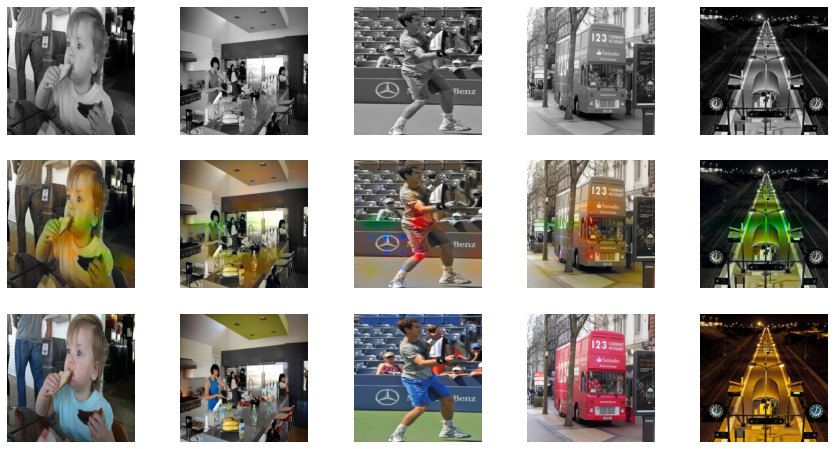

100%|█████████▉| 699/700 [11:50<00:01,  1.01s/it]


Epoch 2/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 38 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


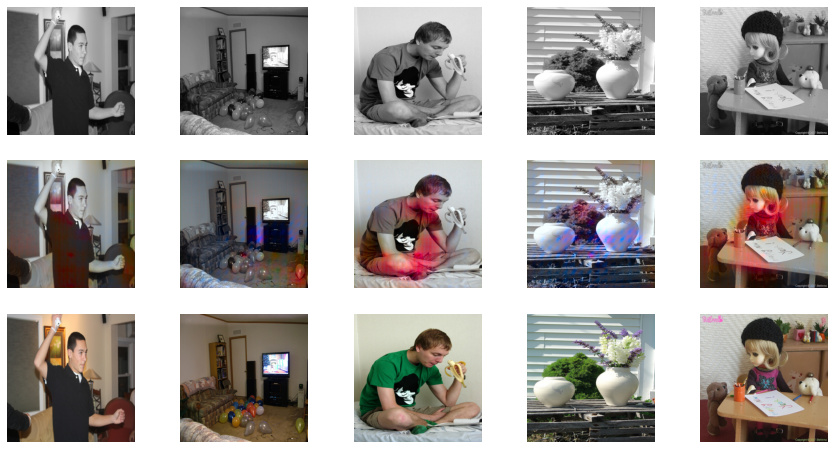

100%|█████████▉| 699/700 [11:45<00:01,  1.01s/it]


Epoch 3/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 68 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 198 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 77 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 123 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Col

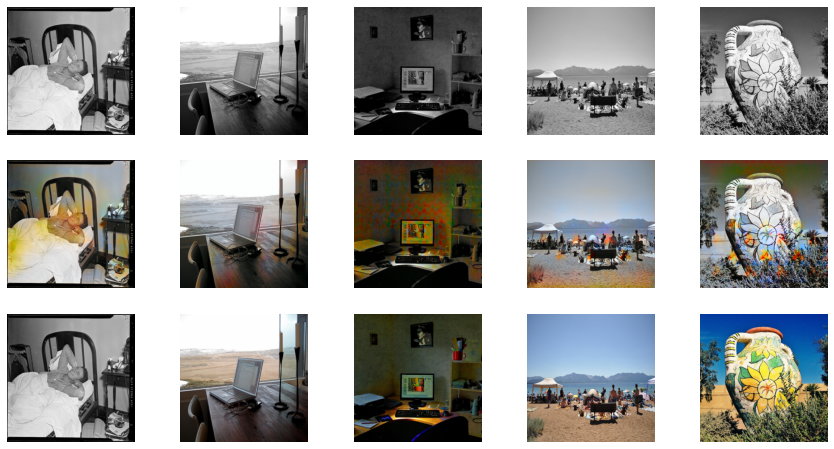

100%|█████████▉| 699/700 [11:39<00:01,  1.01s/it]


Epoch 4/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 415 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 102 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


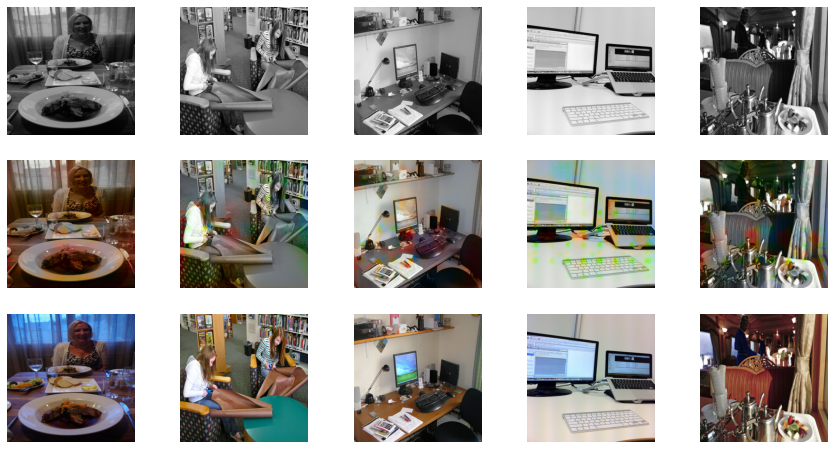

100%|█████████▉| 699/700 [11:40<00:01,  1.01s/it]


Epoch 5/10
Iteration 700/700


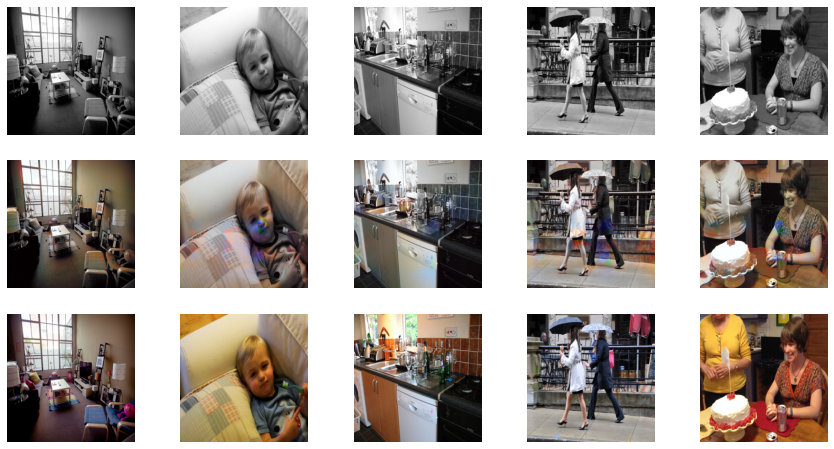

100%|█████████▉| 699/700 [11:49<00:01,  1.01s/it]


Epoch 6/10
Iteration 700/700


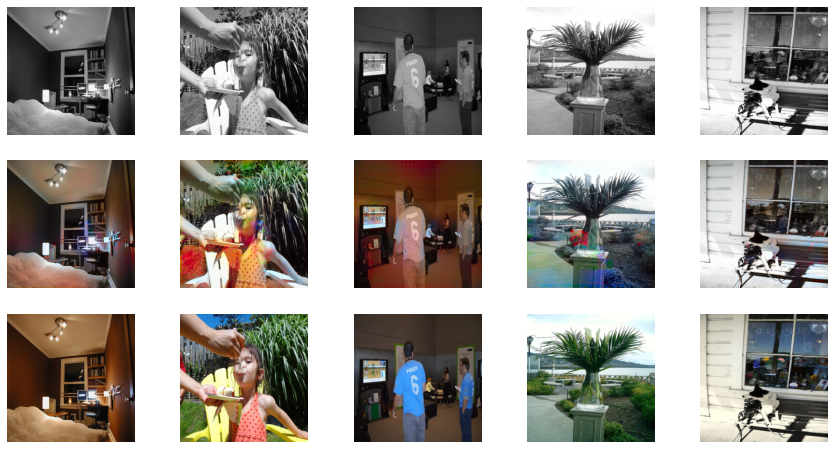

100%|█████████▉| 699/700 [11:47<00:01,  1.01s/it]


Epoch 7/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


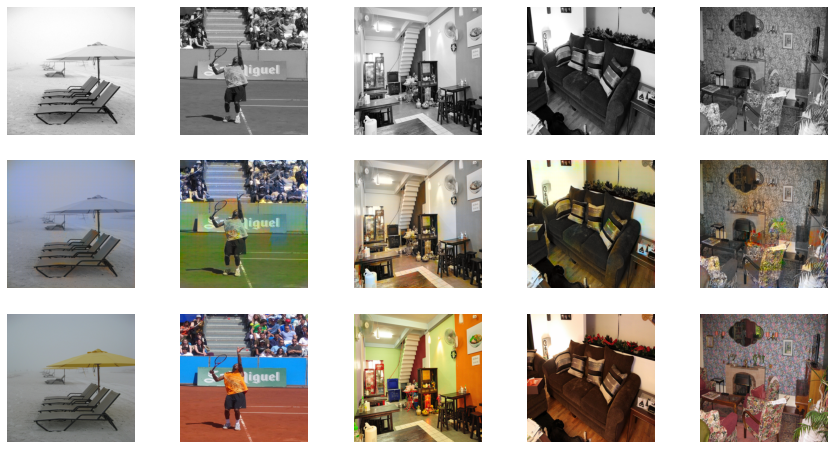

100%|█████████▉| 699/700 [11:42<00:01,  1.01s/it]


Epoch 8/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 20 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 30 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


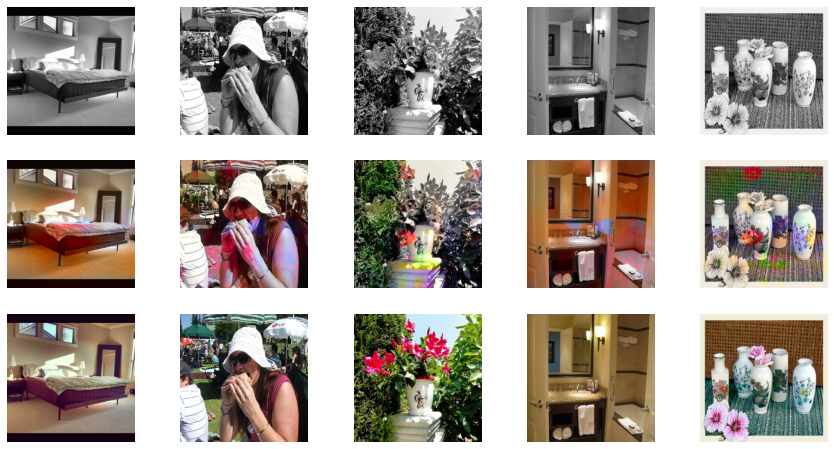

100%|█████████▉| 699/700 [11:43<00:01,  1.01s/it]


Epoch 9/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 36 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


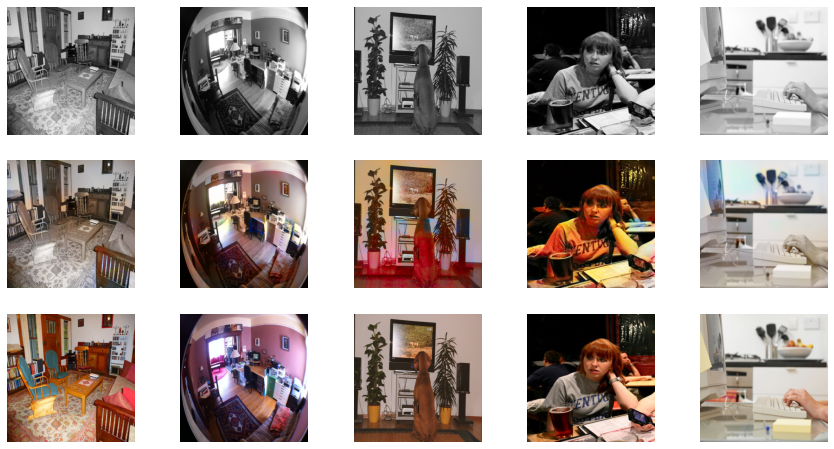

100%|█████████▉| 699/700 [11:51<00:01,  1.03s/it]


Epoch 10/10
Iteration 700/700


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


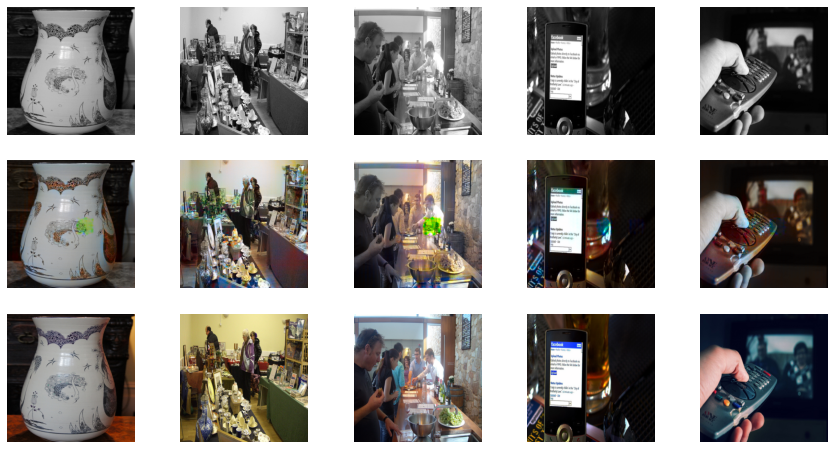

100%|██████████| 700/700 [11:54<00:00,  1.02s/it]


In [25]:
losses = train_model(model, trainloader, 10)

## Plotting the loss graph
In this cell we have plotted the loss graph depicting the Gan Loss

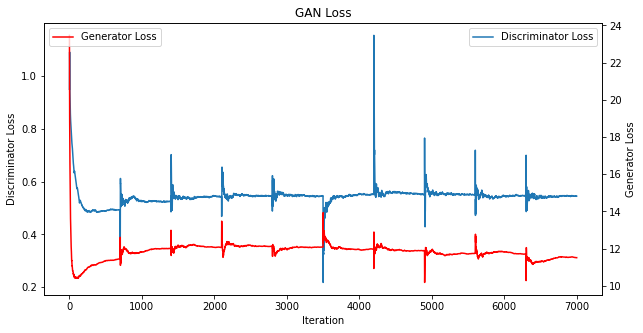

In [26]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.title('GAN Loss')
ax2 = ax1.twinx()
ax1.plot(losses[2])
ax1.set_ylabel('Discriminator Loss')
ax1.set_xlabel('Iteration')
ax2.plot(losses[5],'r')
ax2.set_ylabel('Generator Loss')
ax1.legend(['Discriminator Loss'])
ax2.legend(['Generator Loss'],loc ="upper left")


# Testing the model with the testing dataset

Here we are testing the model with the testing data the results are logged below.

 24%|██▍       | 49/200 [00:12<00:38,  3.89it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 37 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 56 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimag

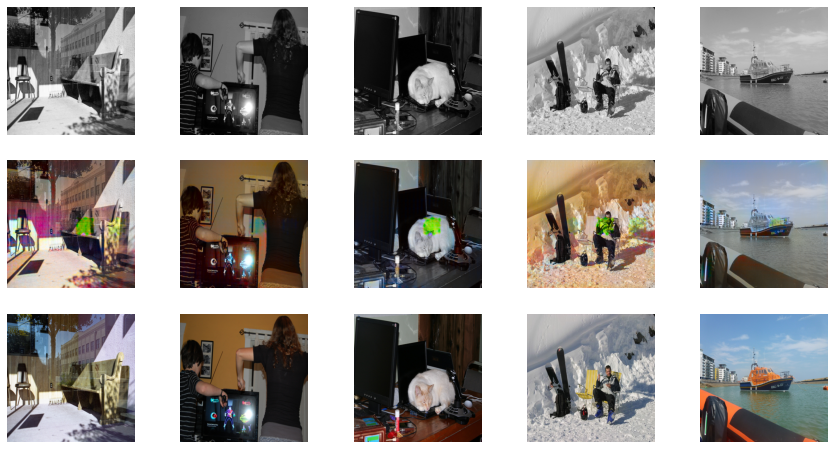

 50%|████▉     | 99/200 [00:27<00:26,  3.87it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 21 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


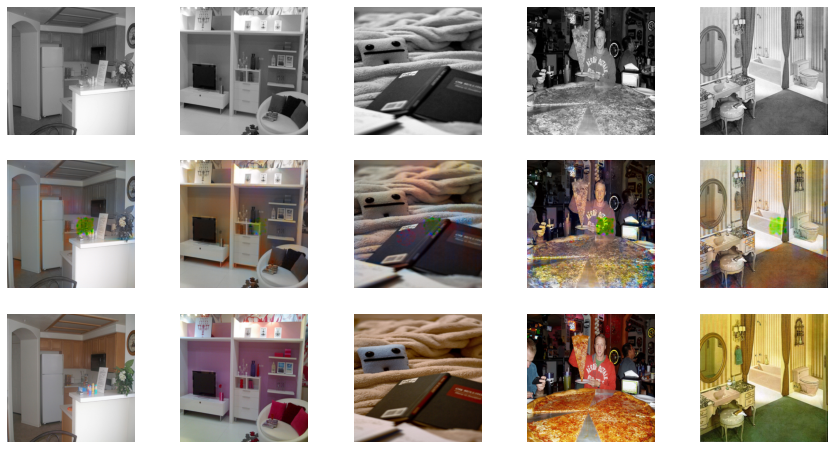

 74%|███████▍  | 149/200 [00:42<00:13,  3.76it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 19 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


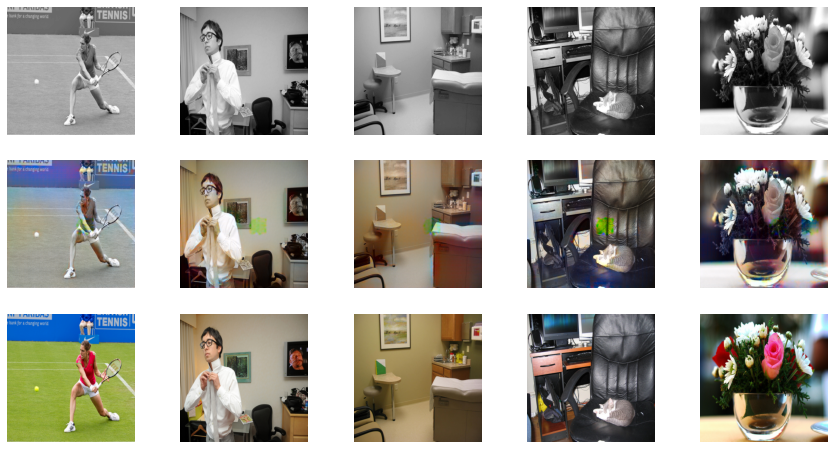

100%|█████████▉| 199/200 [00:58<00:00,  3.59it/s]/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 50 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


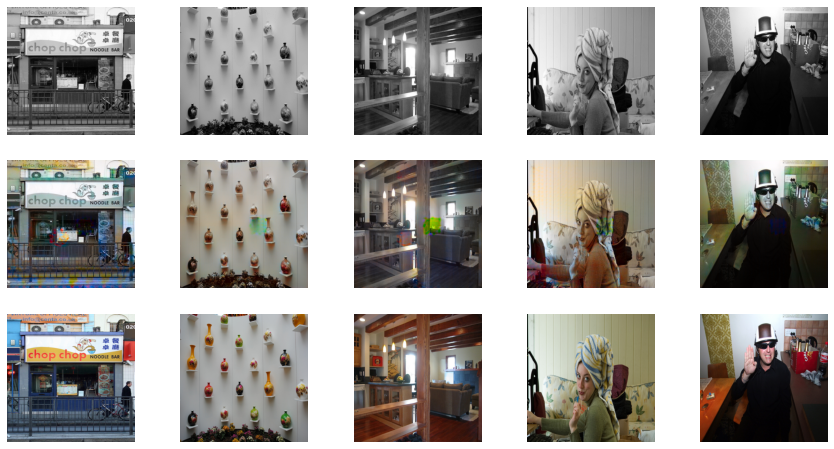

100%|██████████| 200/200 [01:00<00:00,  3.32it/s]


In [32]:
log_every=50
i=0
for data in tqdm(testloader):
    model.setup_input(data)
    i += 1
    if i % log_every == 0:
        visualize(model,data)